In [1]:
from datetime import datetime
from datetime import timezone
import polars as pl
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


start_date = datetime(2023, 9, 4, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 9, 17, 23, 59, 59).replace(tzinfo=timezone.utc)

sensor_id = 4

acropolis_path = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Database/Old"
picarro_path = r"/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Database/PICARRO"

#Calibration
picarro_slope = 1.0061589132696314
picarro_intercept = 0.14607153970888476

acropolis_slope = 1.0178628788793624 
acropolis_intercept = 2.8171086674313415

In [2]:
df = pl.scan_parquet(os.path.join(acropolis_path, "old_db_renamed_measurements.parquet"))

df_a = df.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{sensor_id}" ).sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_a = df_a.with_columns(((pl.col("gmp343_compensated")) * acropolis_slope + acropolis_intercept).alias("gmp343_compensated_corr"))

df_a.tail(3).collect()

creation_timestamp,system_name,variant,gmp343_raw,gmp343_compensated,gmp343_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,gmp343_temperature,cal_bottle_id,wxt532_speed_avg,wxt532_speed_max,wxt532_speed_min,wxt532_direction_avg,wxt532_direction_max,wxt532_direction_min,wxt532_last_update_time,raspi_cpu_usage,raspi_disk_usage,raspi_cpu_temperature,enclosure_bme280_humidity,enclosure_bme280_pressure,enclosure_bme280_temperature,cal_gmp343_raw,cal_gmp343_compensated,cal_gmp343_filtered,gmp343_compensated_corr
"datetime[μs, UTC]",str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-09-17 23:59:33.470 UTC,"""tum-esm-midcos…","""measurement""",406.9,447.6,447.6,54.31,51.4,937.69,23.45,22.91,24.8,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,458.412533
2023-09-17 23:59:43.480 UTC,"""tum-esm-midcos…","""measurement""",409.3,450.4,450.4,54.35,51.4,937.05,23.45,22.91,24.8,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,461.262549
2023-09-17 23:59:53.500 UTC,"""tum-esm-midcos…","""measurement""",406.6,447.7,447.7,54.35,51.42,937.82,23.46,22.9,24.8,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,458.51432


In [3]:
df = pl.scan_parquet(os.path.join(picarro_path, "picarro.parquet"))
df = df.with_columns(pl.col("datetime").dt.cast_time_unit("us").dt.replace_time_zone("UTC").alias("creation_timestamp"))

df_p = df.sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_p = df_p.with_columns((pl.col("CO2_dry") * picarro_slope + picarro_intercept).alias("CO2_corr"))

df_p.tail(3).collect()

DATE,TIME,FRAC_DAYS_SINCE_JAN1,FRAC_HRS_SINCE_JAN1,JULIAN_DAYS,EPOCH_TIME,ALARM_STATUS,INST_STATUS,CavityPressure,CavityTemp,DasTemp,EtalonTemp,species,OutletValve,CH4,CH4_dry,CO2,CO2_dry,h2o_reported,ch4_base,ch4_pzt_std,co2_base,co2_pzt_std,wlm1_offset,wlm2_offset,datetime,__index_level_0__,creation_timestamp,CO2_corr
str,str,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],i64,"datetime[μs, UTC]",f64
"""2023-09-17""","""23:59:53.532""",259.999925,6239.998203,260.999925,1.6950e9,0,963,139.965805,44.999809,43.25,45.153893,2.0,22381.802734,2.058036,2.101561,443.099649,454.569341,2.012013,1181.348031,77.800389,1084.623504,61.172174,-0.074831,-0.044715,2023-09-17 23:59:53.532,3978627,2023-09-17 23:59:53.532 UTC,457.515066
"""2023-09-17""","""23:59:54.447""",259.999936,6239.998458,260.999936,1.6950e9,0,963,139.965805,44.999809,43.25,45.153893,1.0,22381.802734,2.058036,2.101561,443.139285,454.569341,2.012013,1181.348031,77.800389,1084.60733,59.320582,-0.074821,-0.044715,2023-09-17 23:59:54.447,3978628,2023-09-17 23:59:54.447 UTC,457.515066
"""2023-09-17""","""23:59:54.948""",259.999942,6239.998597,260.999942,1.6950e9,0,963,139.965805,44.999809,43.25,45.153893,3.0,22381.802734,2.058036,2.101606,443.139285,454.610269,2.012919,1181.348031,77.800389,1084.60733,59.320582,-0.074821,-0.044715,2023-09-17 23:59:54.948,3978629,2023-09-17 23:59:54.948 UTC,457.556246


In [4]:
filter = '1h'

df_a = df_a.groupby_dynamic("creation_timestamp", every=filter).agg(
                pl.all().exclude("creation_timestamp").mean())

df_p = df_p.groupby_dynamic("creation_timestamp", every=filter).agg(
                pl.all().exclude("creation_timestamp").mean())

/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/acropolis-visualisation/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True

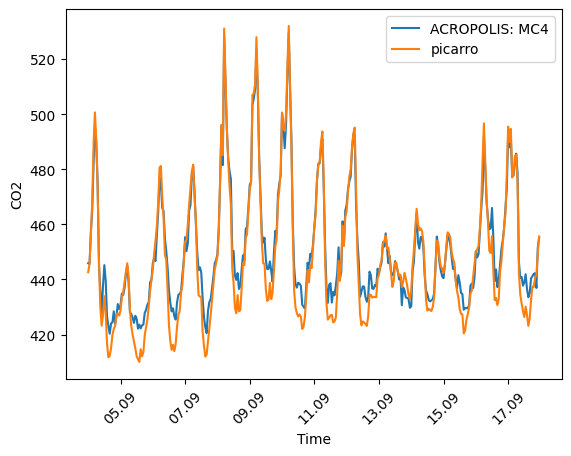

In [5]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="gmp343_compensated_corr", label = f"ACROPOLIS: MC{sensor_id}")
sns.lineplot(data=df_p.collect(), x="creation_timestamp", y="CO2_corr", label = "picarro")

# set axes labels
plt.xlabel("Time")
plt.ylabel('CO2')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

# show the plot
plt.show()

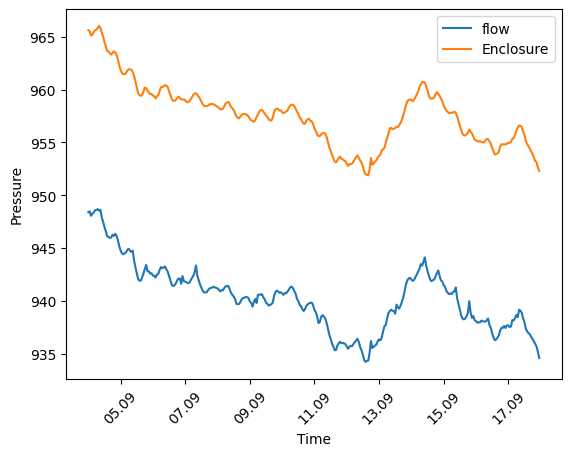

In [6]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="bme280_pressure", label = f"flow")
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="enclosure_bme280_pressure", label = f"Enclosure")

# set axes labels
plt.xlabel("Time")
plt.ylabel('Pressure')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

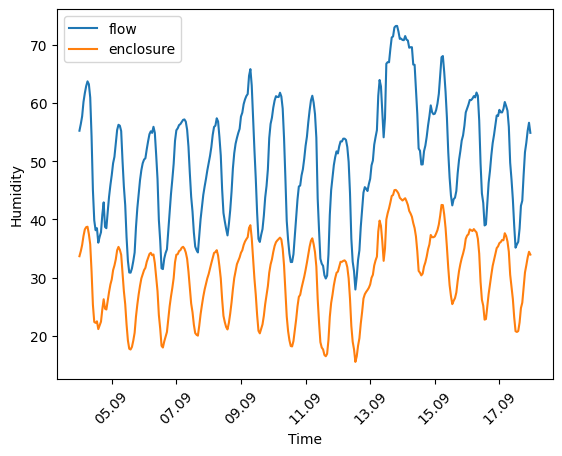

In [7]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="sht45_humidity", label = f"flow")
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="enclosure_bme280_humidity", label = f"enclosure")

# set axes labels
plt.xlabel("Time")
plt.ylabel('Humidity')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

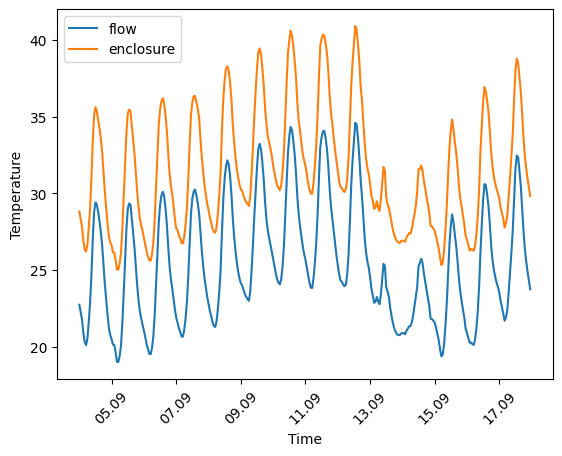

In [8]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="sht45_temperature", label = f"flow")
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="enclosure_bme280_temperature", label = f"enclosure")

# set axes labels
plt.xlabel("Time")
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

In [9]:
df = df_a.join(df_p, left_on= "creation_timestamp", right_on= "creation_timestamp")
df.tail(3).collect()

creation_timestamp,integer,system_name,variant,gmp343_raw,gmp343_compensated,gmp343_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,gmp343_temperature,gas_bottle_id,wxt532_speed_avg,wxt532_speed_max,wxt532_speed_min,wxt532_direction_avg,wxt532_direction_max,wxt532_direction_min,wxt532_last_update_time,raspi_cpu_usage,raspi_disk_usage,raspi_cpu_temperature,enclosure_bme280_humidity,enclosure_bme280_pressure,enclosure_bme280_temperature,gmp343_compensated_corr,DATE,TIME,FRAC_DAYS_SINCE_JAN1,FRAC_HRS_SINCE_JAN1,JULIAN_DAYS,EPOCH_TIME,ALARM_STATUS,INST_STATUS,CavityPressure,CavityTemp,DasTemp,EtalonTemp,species,OutletValve,CH4,CH4_dry,CO2,CO2_dry,h2o_reported,ch4_base,ch4_pzt_std,co2_base,co2_pzt_std,wlm1_offset,wlm2_offset,datetime,__index_level_0__,CO2_corr
"datetime[μs, UTC]",f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],f64,f64
2023-09-17 21:00:00 UTC,1.0620e7,null,null,384.435112,426.467135,426.467135,55.21514,52.017275,935.678989,24.888034,24.368792,26.012079,null,null,null,null,null,null,null,null,0.032964,0.272,53.767857,33.460357,953.121429,30.971429,431.113198,null,null,259.895636,6237.495262,260.895636,1.6950e9,0.0,963.0,139.999449,44.999849,43.598709,45.153699,2.03811,22434.734356,2.098479,2.147812,426.513194,438.774291,2.219192,1181.46305,80.708993,1084.727221,61.951239,-0.074862,-0.044733,null,3607526.5,441.622735
2023-09-17 22:00:00 UTC,1.0626e7,null,null,397.916389,440.755833,440.755833,56.58775,53.471889,935.196389,24.292583,23.765111,25.648333,null,null,null,null,null,null,null,null,0.033111,0.272,53.140741,34.441481,952.616296,30.377037,446.382006,null,null,259.937791,6238.506982,260.937791,1.6950e9,0.0,963.0,139.999552,44.999909,43.465713,45.153946,2.02079,22410.966783,2.095294,2.144077,434.169407,446.522866,2.198197,1181.453457,80.40699,1084.725126,62.403922,-0.074866,-0.04473,null,3609472.5,449.419033
2023-09-17 23:00:00 UTC,1.0633e7,null,null,401.554062,444.281513,444.281513,54.854874,51.837675,934.595826,23.733361,23.197339,25.039216,null,null,null,null,null,null,null,null,0.033036,0.272,52.635714,33.959286,952.305714,29.810357,450.149524,null,null,259.979477,6239.50745,260.979477,1.6950e9,0.0,963.0,139.999336,44.999898,43.314357,45.15391,2.020367,22397.928884,2.066349,2.111275,440.96112,452.678088,2.062532,1181.370328,79.33567,1084.684629,62.769905,-0.074864,-0.044731,null,3611416.5,455.612165


<Axes: xlabel='gmp343_compensated_corr', ylabel='CO2_corr'>

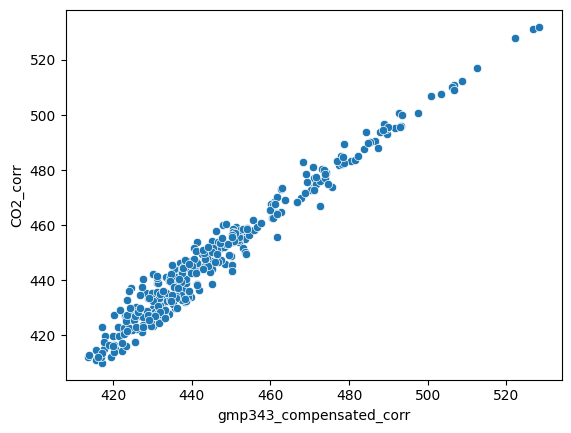

In [10]:
sns.scatterplot(data = df.collect(), x= "gmp343_compensated_corr", y = "CO2_corr" )